# Take Home Challenge-2: Relax_Challenge

The data is available as two attached CSV files:
takehome_user_engagement.csv
takehome_users.csv

The data has the following two tables:

1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

● name: the user's name

● object_id: the user's id

● email: email address

● creation_source: how their account was created. This takes on one of 5 values:
    
    ○ PERSONAL_PROJECTS: invited to join another user's personal workspace
    
    ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)
    
    ○ ORG_INVITE: invited to an organization (as a full member)
    
    ○ SIGNUP: signed up via the website
    
    ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

● creation_time: when they created their account

● last_session_creation_time: unix timestamp of last login

● opted_in_to_mailing_list: whether they have opted into receiving marketing emails

● enabled_for_marketing_drip: whether they are on the regular marketing email drip

● org_id: the organization (group of users) they belong to

● invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.neural_network import MLPClassifier
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string

In [2]:
df = pd.read_csv("takehome_users.csv", encoding='latin-1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
take_user_eng = pd.read_csv("takehome_user_engagement.csv")
take_user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
take_user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
print('There are {} users who have ever used the application.'\
          .format(take_user_eng['user_id'].nunique()))
print('There are {} signed up for the application.'\
          .format(df['object_id'].nunique()))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.


In [6]:
# how many people never signed in?
print('There are ', len(df[df['last_session_creation_time'].isnull()]), 'inactive users.')

There are  3177 inactive users.


## Task 1: Find Adopted Users 

In [7]:
take_user_eng['time_stamp'] = pd.to_datetime(take_user_eng['time_stamp'])
# How many values does 'visited' take?
take_user_eng['visited'].unique()

array([1], dtype=int64)

In [8]:
ses_stats = pd.Series([])
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = take_user_eng.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)

0    10398
1     1602
Name: adopted_user, dtype: int64


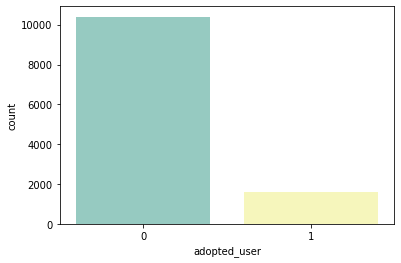

In [9]:
print(df['adopted_user'].value_counts())
sns.countplot(df['adopted_user'],palette="Set3")
plt.show()

In [11]:
print('Total percentage of the adopted users are:',100*df['adopted_user'].sum()/df['adopted_user'].count(),'%')

Total percentage of the adopted users are: 13.35 %


### Total percentage of the adopted users are: 13.35 %. 

## Task 2: Identify Factors That Can Predict Future Adopted Users 

In [12]:
df.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0


### 2.1 Find Domain Emails for Each ID 

In [13]:
df['email'] = df['email'].apply(lambda x: x[x.find('@')+1:]) #only keep the content after @, such as yahoo.com
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']

#label no domain email, and only keep the content of domain email before '.com'
df['email'] = df['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')]) 

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64


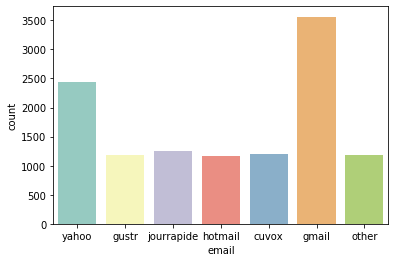

In [14]:
print(df['email'].value_counts())
sns.countplot(df['email'],palette="Set3")
plt.show()

### Observation: most emails are gmail domain.

### 2.2 Data Wrangling

In [15]:
#deal with time series variables: create new columns: the hour, month and year.
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['hour'] = df['creation_time'].apply(lambda x: x.hour)
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [16]:
#fill in missing values and drop the unnecessary columns
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())
df.drop(['name', 'creation_time','invited_by_user_id'], axis=1, inplace=True)

In [17]:
#Change columns with string values to integers
df.email = pd.Categorical(df.email)
df['email'] = df.email.cat.codes

df.creation_source = pd.Categorical(df.creation_source)
df['creation_source'] = df.creation_source.cat.codes

df.head()

,object_id,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,hour,month,year
0,1,6,0,1.398139e+09,1,0,11,0,3,4,2014
1,2,2,1,1.396238e+09,0,0,1,1,3,11,2013
2,3,2,1,1.363735e+09,0,0,94,0,23,3,2013
3,4,6,0,1.369210e+09,0,0,1,0,8,5,2013
4,5,6,0,1.358850e+09,0,0,193,0,10,1,2013


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
email                         12000 non-null int8
creation_source               12000 non-null int8
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
adopted_user                  12000 non-null int64
hour                          12000 non-null int64
month                         12000 non-null int64
year                          12000 non-null int64
dtypes: float64(1), int64(8), int8(2)
memory usage: 867.3 KB


### 2.3 Model Evaluation

In [19]:
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)

### Information Value Analysis and Multicollinearity 

In [20]:
#Calculate IV score for each column
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string


max_bin = 20
force_bin = 3

#For some numeric variables, the mono_bin function produce only one category while binning. 
#To avoid that, ‘force_bin’ to ensure it at least produces 2 categories.

# define a binning function
def mono_bin(Y, X, n = max_bin): #mono_bin for numeric variables
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X): #char_bin for character variables
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [21]:
final_iv, IV = data_vars(X_train, y_train)

In [22]:
IV[(IV['IV']>0.01) & (IV['IV']<0.8)]

,VAR_NAME,IV
0,creation_source,0.010401
1,email,0.014863
5,month,0.027260
8,org_id,0.064601
9,year,0.091286


In [23]:
#Multicollinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [24]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

In [25]:
#Calculate IVF of each selected column, and drop the column with high IVF to avoid multicollinearity
def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)
X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing year with VIF of 10.200000
Iteration # 2
Complete


In [26]:
X_train=final_df
X_test=X_test[X_train.columns]

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [28]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
            nthread=4,
            n_estimators=200,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

def eval(X_test, y_test, pthresh):
    y_predict=clf.predict_proba(X_test)
    ypredict = y_predict[:,1]
    y_pred=[]
    #convert into binary values
    for i in range(len(ypredict)):
        if ypredict[i]>=pthresh:
            y_pred.append(1)
        else:
            y_pred.append(0)

    print('\nConfusion_matrix:  \n', confusion_matrix(y_test, y_pred))
    print('\nClassification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('ROC-AUC score of the model:   {}'.format(roc_auc_score(y_test, ypredict)))

eval(X_test, y_test, 0.3)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.690425	training's binary_logloss: 0.369463	valid_1's auc: 0.63088	valid_1's binary_logloss: 0.376828
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.690425	training's binary_logloss: 0.369463	valid_1's auc: 0.63088	valid_1's binary_logloss: 0.376828

Confusion_matrix:  
 [[3112   15]
 [ 463   10]]

Classification report: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3127
           1       0.40      0.02      0.04       473

    accuracy                           0.87      3600
   macro avg       0.64      0.51      0.48      3600
weighted avg       0.81      0.87      0.81      3600


ROC-AUC score of the model:   0.6308804648323171


In [29]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=200,
                            random_state=42)

# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.5109166497078232

In [30]:
from sklearn import datasets
import xgboost as xgb

xg_classifier = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 100)

xg_classifier.fit(X_train, y_train)

y_pred2 = xg_classifier.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.5

In [31]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_seed=42,
                         logging_level='Silent',
                         eval_metric='Accuracy')

cat.fit(X_train, y_train)

y_pred2 = cat.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.49984010233450593

### Deal with Imbalanced Dataset 

[(0, 10398), (1, 10398)]


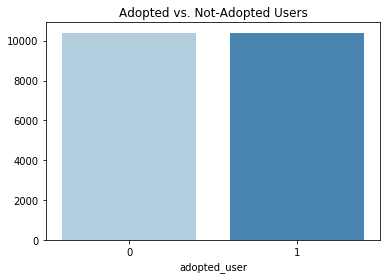

In [32]:
# Since the dataset is unbalanced, SMOTE oversampling is used to balance out the classes
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled =SMOTE().fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

sns.countplot(y_resampled, palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.30, random_state=0)

In [34]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
            nthread=4,
            n_estimators=200,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

def eval(X_test, y_test, pthresh):
    y_predict=clf.predict_proba(X_test)
    ypredict = y_predict[:,1]
    y_pred=[]
    #convert into binary values
    for i in range(len(ypredict)):
        if ypredict[i]>=pthresh:
            y_pred.append(1)
        else:
            y_pred.append(0)

    print('\nConfusion_matrix:  \n', confusion_matrix(y_test, y_pred))
    print('\nClassification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('ROC-AUC score of the model:   {}'.format(roc_auc_score(y_test, ypredict)))

eval(X_test, y_test, 0.3)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.996839	training's binary_logloss: 0.0922965	valid_1's auc: 0.995073	valid_1's binary_logloss: 0.103041
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.996839	training's binary_logloss: 0.0922965	valid_1's auc: 0.995073	valid_1's binary_logloss: 0.103041

Confusion_matrix:  
 [[3021   94]
 [  77 3047]]

Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3115
           1       0.97      0.98      0.97      3124

    accuracy                           0.97      6239
   macro avg       0.97      0.97      0.97      6239
weighted avg       0.97      0.97      0.97      6239


ROC-AUC score of the model:   0.9950734026220653


In [35]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators=200,
                            random_state=42)

# Train the model on training data
rf.fit(X_train, y_train)

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.9772519180455563

In [36]:
from sklearn import datasets
import xgboost as xgb

xg_classifier = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 8, alpha = 10, n_estimators = 100)

xg_classifier.fit(X_train, y_train)

y_pred2 = xg_classifier.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.9543326866202322

In [37]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_seed=42,
                         logging_level='Silent',
                         eval_metric='Accuracy')

cat.fit(X_train, y_train)

y_pred2 = cat.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.9788427192367689

###### lightgbm shows the best classifier with prediction score 99%.

### Conclusions 
1. About 13.35 % of the userbase are the adopted users.This clearly indicates that there is a lot that can be done to decrease this proportion relative to the number of adopted users.
2. After removing 'year', 'org_id' is the most important feature when it comes to predicting adopted users. 
3. Email and creating source is the next most important information. However, its importance is negligible compared to 'org_id'.
4. All the other features have close to zero importance and do not explain the target variable well.
5. My recommendations at this point would be to identify the top sources of engaged users (sign-up origin) and increase marketing efforts there. Further, we can conduct more detailed surveys amoungst adopted users to attempt to identify new common features to add to the model that may increase its validity.